# Task Details

The attached data-set shows the happiest countries on earth. You may join any data you want to explain why countries are ranked as they are here.

The goal of this task is to find out what factors contribute to happiness. You can join any other data and use any insights you might have that show a strong correlation between the factors you come up with.  

Expected Submission We want the final code to be submitted on Github and a demo of it in the final interview.  

Please use comments to explicit the code.  The solution should contain the correlation between the factors discovered and the happiness score of the data-set (the actual number).  Any charts explaining this correlation will also help.  Evaluation The best solutions will both have a good correlation score, but are also creative and explain the work well.


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from scipy import stats


%matplotlib inline

## Load a sample dataset

In [2]:
partial_dataset = pd.read_csv('./data/2015.csv')

In [3]:
# view dataset columns
partial_dataset.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

### Trying to understand the format of the data:


* Country - The name of the country that is studied
* Region - Location on the world map
* Happiness Rank - How high is this country ranked?
* Happiness Score - I'll take this as an axiomatic measurement of happiness
* Standard Error - Measure of the width of the sampling distribution (will assume that it's for the happiness score)
* Economy (GDP per capita) - how much each citizen contributes to the economy on average
* Health (Life Expectancy)
* Freedom - this raises some red flags as it would seem hard to measure
* Trust - government corruption. Same as freedom, but I can see it being easier to quantify.
* Generosity - same issue as the two above, but of all of them this can easily be quantified economically.
* Dystopia residual: I found the explanation below in the official world happiness report:

### What is Dystopia?
Dystopia is an imaginary country that has the world’s least-happy people. The purpose in establishing Dystopia is to have a benchmark against which all countries can be favorably compared (no country performs more poorly than Dystopia) in terms of each of the six key variables, thus allowing each sub-bar to be of positive (or zero, in six instances) width. The lowest scores observed for the six key variables, therefore, characterize Dystopia. Since life would be very unpleasant in a country with the world’s lowest incomes, lowest life expectancy, lowest generosity, most corruption, least freedom, and least social support, it is referred to as “Dystopia,” in contrast to Utopia.

### What are the residuals?
The residuals, or unexplained components, differ for each country, reflecting the extent to which the six variables either over- or under-explain average 2017-2019 life evaluations. These residuals have an average value of approximately zero over the whole set of countries. Figure 2.1 shows the average residual for each country if the equation in Table 2.1 is applied to average 2017- 2019 data for the six variables in that country. We combine these residuals with the estimate for life evaluations in Dystopia so that the combined bar will always have positive values. As can be seen in Figure 2.1, although some life evaluation residuals are quite large, occasionally exceeding one point on the scale from 0 to 10, they are always much smaller than the calculated value in Dystopia, where the average life is rated at 1.97 on the 0 to 10 scale. Table 7 of the online Statistical Appendix 1 for Chapter 2 puts the Dystopia plus residual block at the left side, and also draws the Dystopia line, making it easy to compare the signs and sizes of the residuals in different countries.




# Load the entire dataset

I've manually merged together the 2015, 2016, and 2017 csv files and dropped the columns that were not in common to all the years. This is to facilitate extracting some form of strong correlation between happiness and other variables in our exploration.

I've eliminated the data for 2018 and 2019 as those have a different scaling for certain measurements and need to be studied separately, or renormalized to fit with the other data.

I also found some outliers that were clearly mistakes in the data (orders of magnitude higher), and removed them.

In [4]:
path = './data'

dataset = pd.read_csv('./data/aggregate.csv')

dataset.columns
    

Index(['Happiness Score', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

### Create a Sample Correlation Matrix

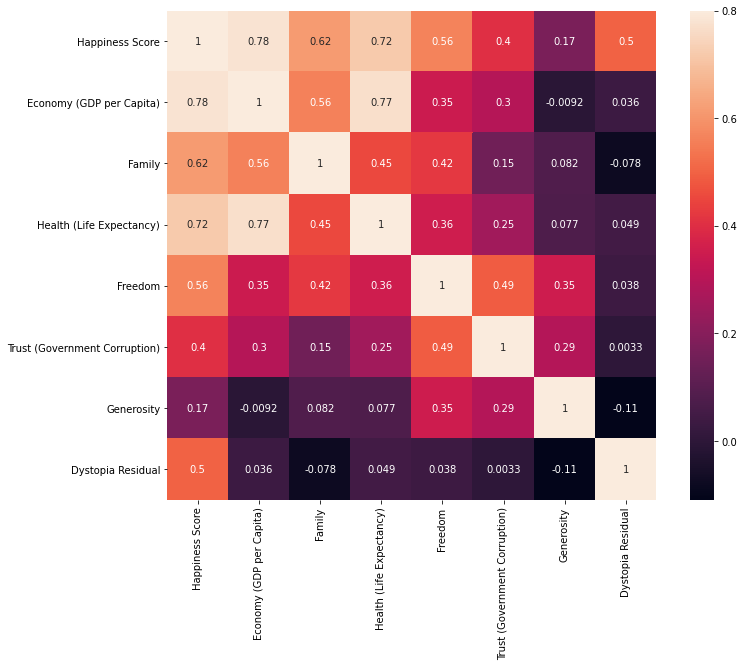

In [5]:
correlation_matrix = dataset.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(correlation_matrix, vmax=.8, square = True, annot = True);
    




Looking at the table above, we can see the correlations computed between each pair of variables we have in our dataset.

We are only interested in the one between the happiness score and the others.

Generosity and low government corruption rank the lowest in pure correlation with 0.4 and 0.17, respectively.

The highest three are Economy, Life expectancy, and Family.



### Create scatterplots

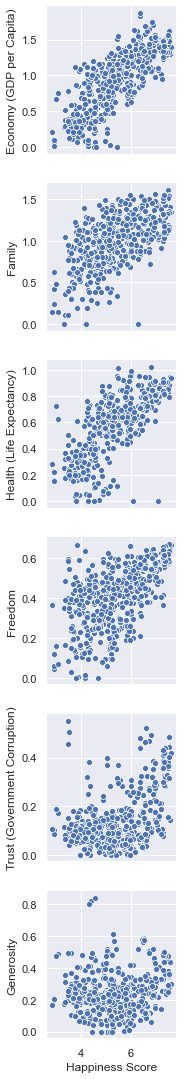

In [6]:
sns.set()
cols = ['Happiness Score','Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity']
sns.pairplot(dataset[cols], x_vars=['Happiness Score'], y_vars = ['Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity'])
plt.show()

The above charts all have happiness score on the X axis, and the different other values on the Y axis. This allows us to visually see whether there might be a strong correlation that is worth exploring (data clusters together attempting to form a line). We can see that the measurements with the highest correlation are less random, and cluster together near an imaginary line. I'll use regression below to plot those lines for easier visualization.

### Applying a simple linear regression to each scatterplot

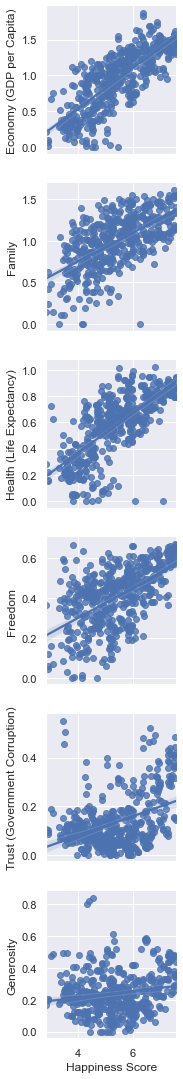

In [7]:
regression_plots = sns.pairplot(dataset[cols], x_vars=['Happiness Score'], y_vars = ['Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity'], kind="reg")

To have an ideal clear relationship, we want the points to be as close to the regression line on average as possible. Visually, we can see that going from top to bottom the charts get messier, which was also reflected in the correlation computations.

### Thoughts

*“Statistics isn't about discovering correlations, it's about eliminating coincidence.”*

Let's try and determine whether there is a significant statistical result for our highest correlation, between Economy (GDP per capita) and happiness.

Our highest correlation was 0.78.

We'll use an alpha value of 0.05 for this test (commonly used) to determine the probability of our correlation being random.

This test is used to determine the probability that our result is not random, and represents a true correlation.

For this we will compute a p-score, which is then compared with a threshold alpha value. If the p-score is below our chosen alpha, theoretically it means that our correlations are statistically significant.



<Figure size 432x288 with 0 Axes>

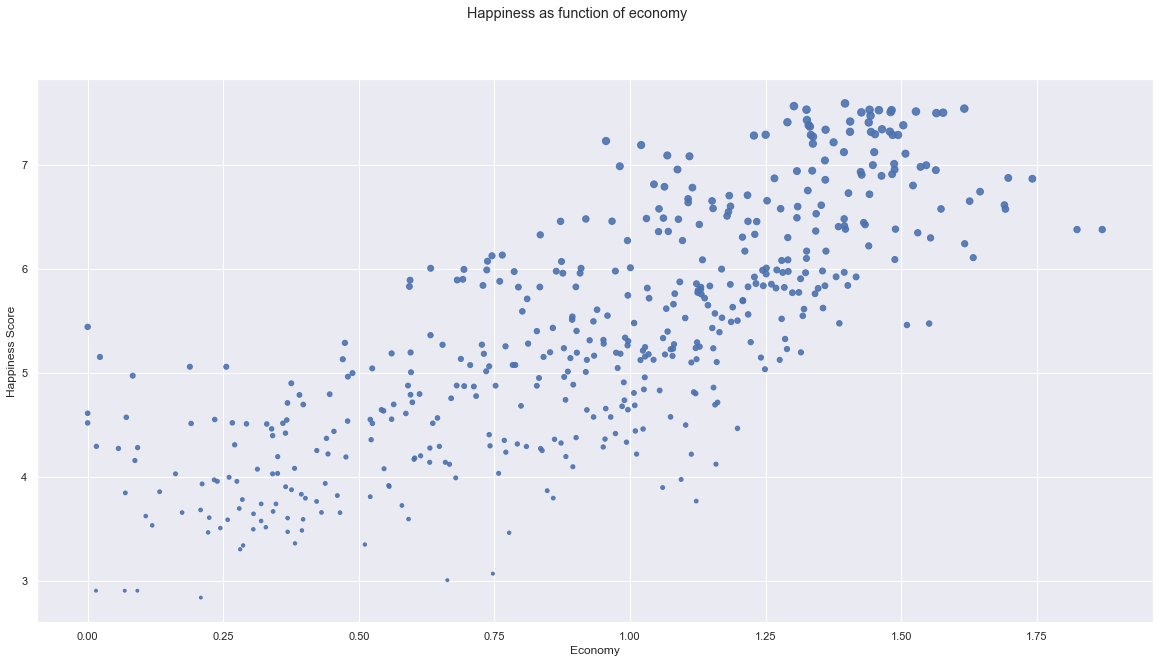

In [8]:
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(dataset['Economy (GDP per Capita)'], dataset['Happiness Score'], s=(dataset['Happiness Score']**2), alpha=0.9)

plt.xlabel("Economy")
plt.ylabel("Happiness Score")

plt.suptitle("Happiness as function of economy")

plt.show()

In [9]:
correlation, pvalue = stats.pearsonr(dataset['Economy (GDP per Capita)'], dataset['Happiness Score'])

print("Correlation: " + str(correlation))
print("P-value: " + str(pvalue))

Correlation: 0.7800181072671323
P-value: 1.6142801903475359e-96


As we can see, the p-value is tiny, which is an indicator of high statistical significance. Anything under 0.05 is normally considered significant.

Let's try it for all the variables

In [10]:
cols = ['Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity']

for column in cols:
    correlation, pvalue = stats.pearsonr(dataset['Happiness Score'], dataset[column])
    
    print("Correlation for " + column + " is " + str(correlation))
    print("P-value for " + column + " is " + str(pvalue))
    print()

Correlation for Economy (GDP per Capita) is 0.7800181072671323
P-value for Economy (GDP per Capita) is 1.6142801903475359e-96

Correlation for Family is 0.6150994450377473
P-value for Family is 7.604566518316134e-50

Correlation for Health (Life Expectancy) is 0.7211015953337209
P-value for Health (Life Expectancy) is 5.756826441351206e-76

Correlation for Freedom is 0.5624483728215068
P-value for Freedom is 3.1483883534619557e-40

Correlation for Trust (Government Corruption) is 0.40338374580363434
P-value for Trust (Government Corruption) is 1.159449088963992e-19

Correlation for Generosity is 0.17159524132605786
P-value for Generosity is 0.00019770925937113697



# Conclusion

Because we have a pretty large sample size (hundreds of datapoints) all of them are deemed as statistically significant. The data does seem non-random when plotted on a chart.

However, in these kinds of applications there are lots of issues:

1. Measurements cannot be precise, because we are measuring subjective values.

2. Correlations can be spurious. You can easily generate a random dataset with a high correlation that says nothing about reality. Your confirmation bias will make you think there is a relationship there.

3. Related to the above point, correlation does not imply causation. Even in the case where you do have a high correlation, you cannot draw any conclusions.

4. Directionality: if there is a causal relationship, what is its direction? This may be harder than initially assumed. For example, do economically developed countries give rise to well educated populations? Or does education increase economic power? In our case, do happy people create free and prosperous countries? Or the reverse?

We can intuitively tell that the results here make sense. It is logical that everyone wants financial security, good healthcare, good relationships and low corruption.

However, I'd suggest refraining from drawing any deeper conclusions from correlations like these, or using them for any type of policy making.